# Target
We will use California's 1990 census data to create a house price model to predict the median house price in a given area.
To achieve this target, we will comply the 8 basic step that book introduces strictly

# Step1: Define the problem and consider the big picture.
**Bussiness goal**: the output of this model will be transformed to the other machine learning system with other signals, and this downstream system will be used to decide whether it is worth investing.
**Current solution**: Currently the house price is estimated manually by Expert team, when they can't get the median house price they will use difficult rule to estimate it. But the process are expensive and time-consuming, and the estimated house price deviates from actual house price by as much as 20%. That is why this company belive some other data in a given area is helpful for predicating median house price, because they are including thousands of area's median house price and other data.

# Step2: Get data
Download data from githubusercontent

In [85]:
import os
import tarfile
import urllib
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing_homework")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

print("当前工作目录:", os.getcwd())
print("完整路径:", os.path.abspath(HOUSING_PATH))

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path, filter='data')
    housing_tgz.close()

fetch_housing_data()

当前工作目录: C:\Users\tjtgc\my_env\Scripts
完整路径: C:\Users\tjtgc\my_env\Scripts\datasets\housing_homework


Use pandas to load data

In [86]:
import pandas

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pandas.read_csv(csv_path)

Check dta frames

In [87]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [88]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [89]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


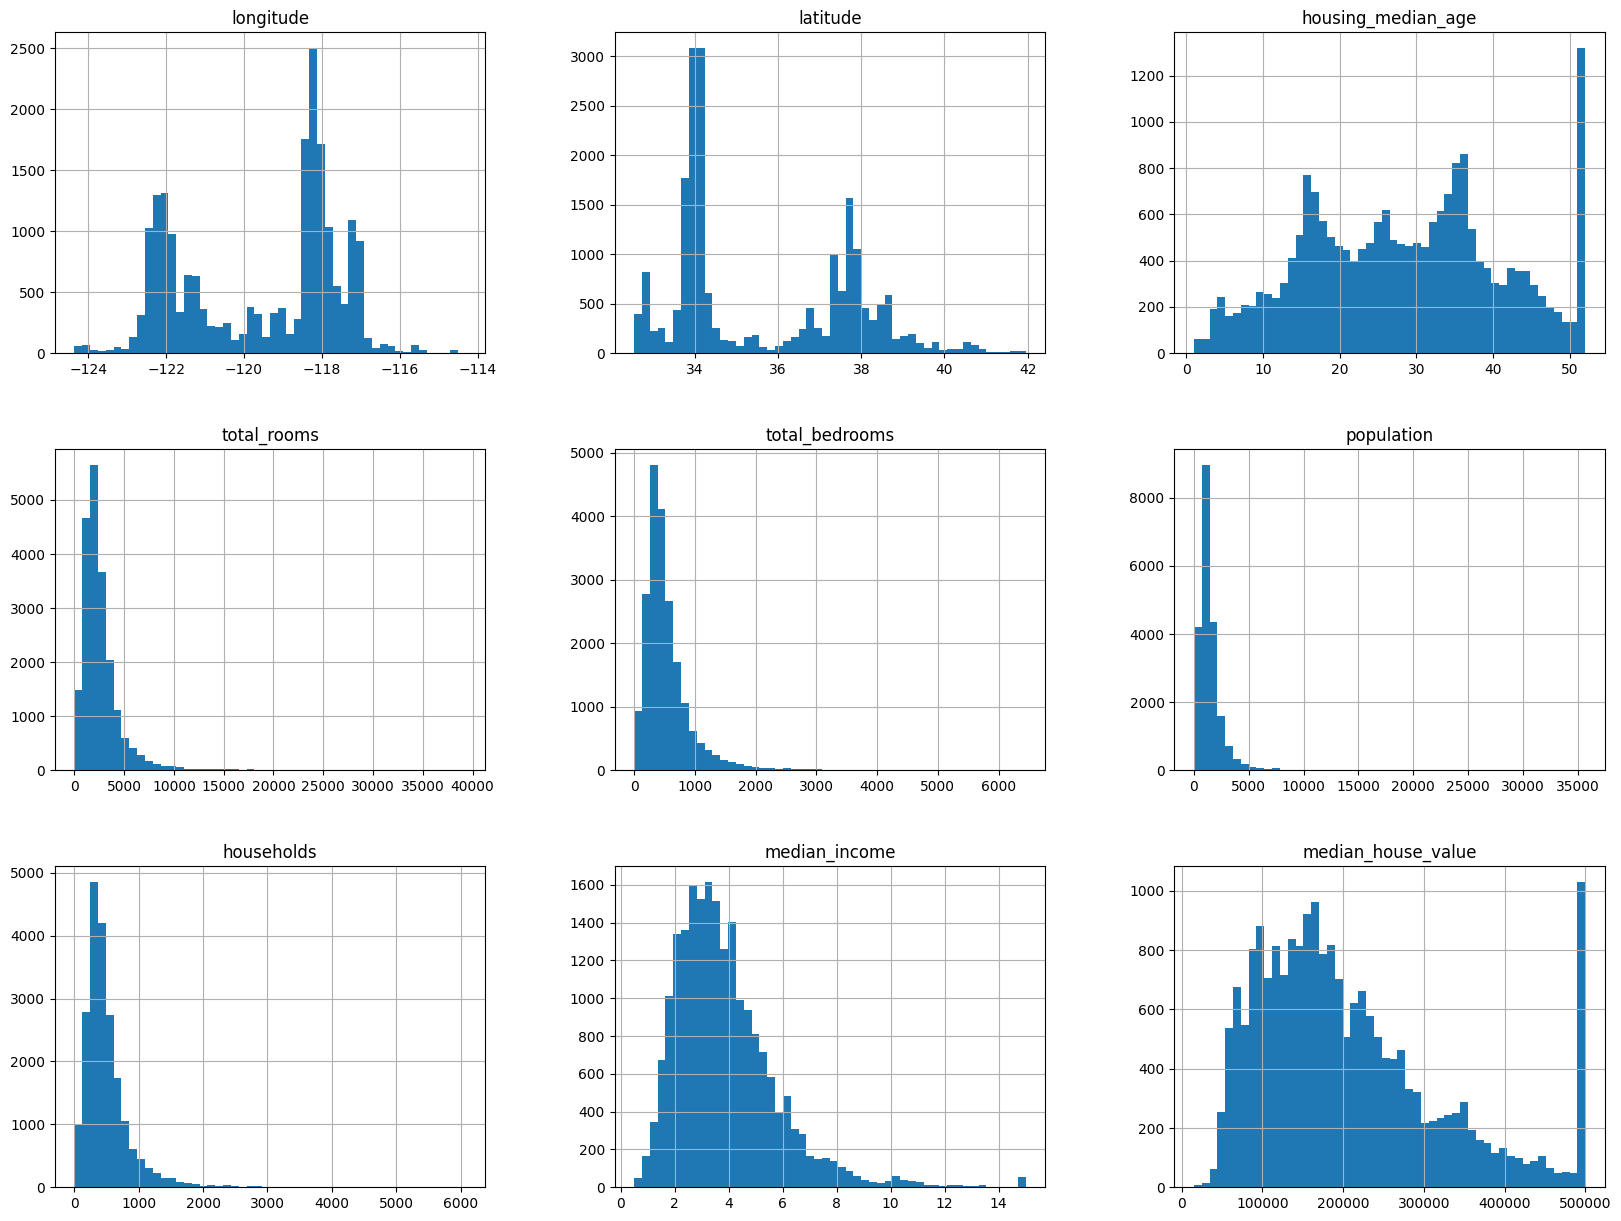

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

# Creating a test suite

**Method 1**: we use random method to creat test suite

In [91]:
import numpy as np

def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

**Method 2**: But `Method 1` is unstable even it can get a fix data. When other data added and data size changed, test data will also be changed. So we can consider to create test suite by hash value

In [92]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32

def split_rain_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()
train_set, test_set = split_rain_test_by_id(housing_with_id, 0.2, "index")

But use line index as the unit flag, we should promise add new data at the end of test suite and not delete any line. Other wise, line index will be changed and test suite will be instable. The latitude of area is fixed, we can combine lontitude and latitude as the unit index.

In [93]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_rain_test_by_id(housing_with_id, 0.2, "id")

`Scikit-learn` provides some method that splits maulty subsets by many method. The easit method is `train_test_split()`

In [94]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state=42)

Create a income property

In [95]:
import pandas as pd
housing["income_cat"] = pd.cut(housing["median_income"], bins = [0., 1.5, 3.0, 4.5, 6., np.inf], labels = [1, 2, 3, 4, 5])

<Axes: >

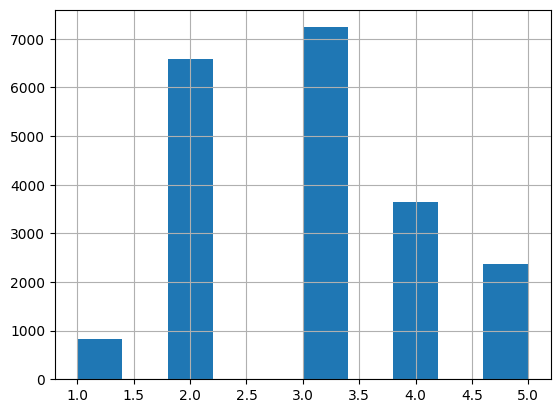

In [96]:
housing["income_cat"].hist()

In [97]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  object  
 10  income_cat          20640 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.6+ MB


Create an explore set to understand data deeply

In [98]:
explore = train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

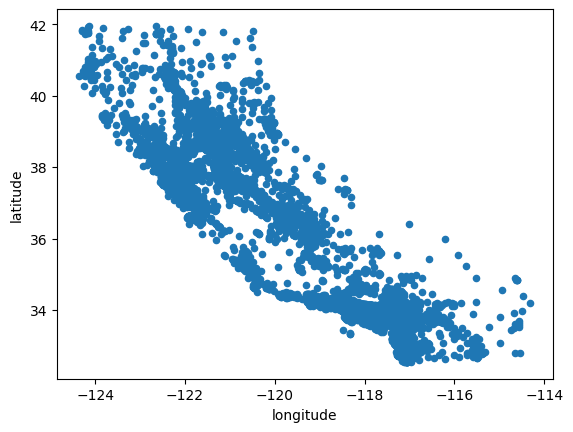

In [99]:
explore.plot(kind = "scatter", x = "longitude", y = "latitude")

<Axes: xlabel='longitude', ylabel='latitude'>

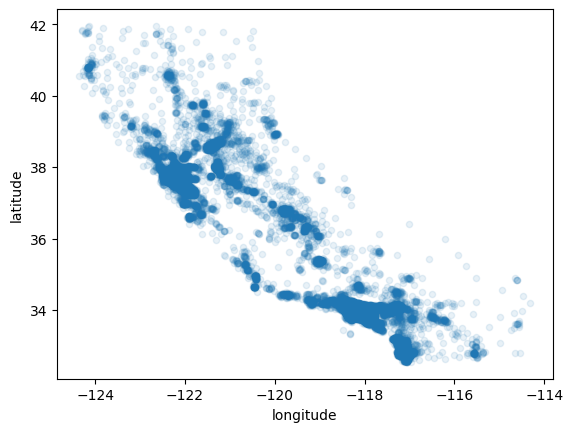

In [100]:
explore.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)

<Axes: xlabel='longitude', ylabel='latitude'>

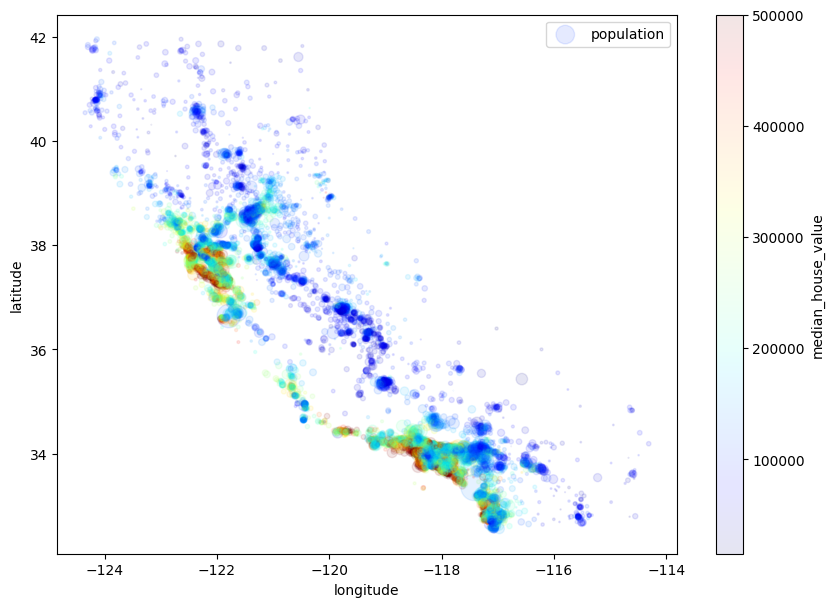

In [101]:
explore.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1,
             s = explore["population"]/100, label = "population", figsize = (10, 7),
             c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True)

In [102]:
explore.drop(columns = ["ocean_proximity"])
corr_matrix = explore.corr(numeric_only = True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

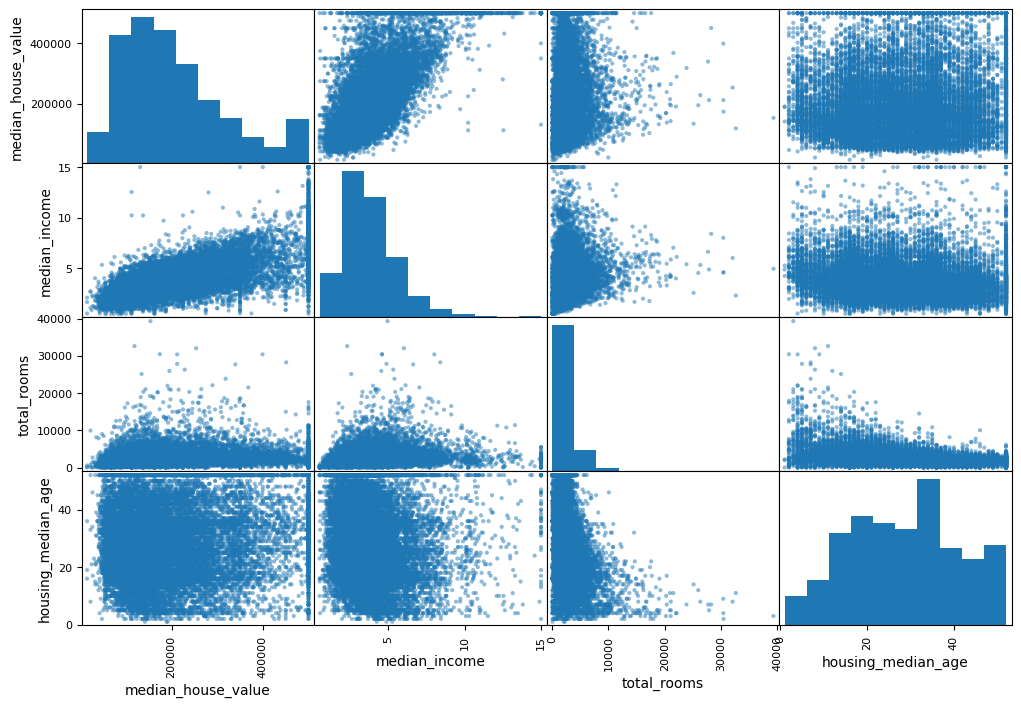

In [103]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(explore[attributes], figsize = (12, 8))

In [104]:
explore["rooms_per_household"] = explore["total_rooms"] / explore["households"]
explore["bedrooms_per_room"] = explore["total_bedrooms"] / explore["total_rooms"]
explore["population_per_household"] = explore["population"] / explore["households"]

In [105]:
corr_matrix = explore.corr(numeric_only = True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690647
rooms_per_household         0.158485
total_rooms                 0.133989
housing_median_age          0.103706
households                  0.063714
total_bedrooms              0.047980
population_per_household   -0.022030
population                 -0.026032
longitude                  -0.046349
latitude                   -0.142983
bedrooms_per_room          -0.257419
Name: median_house_value, dtype: float64

Let's do some preperation for ML

In [106]:
housing_train = train_set.copy()
housing_cat = housing_train[["ocean_proximity"]].copy()
housing_labels = train_set["median_house_value"].copy()

Process text attributes

In [107]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1Hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1Hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [108]:
housing_train_encoded = pd.get_dummies(housing_train, columns=["ocean_proximity"], prefix = "ocean_proximity")
housing_labels_encoded = housing_train_encoded.drop("median_house_value", axis=1)

In [109]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [110]:
housing_train_without_ocean = housing_train.drop("ocean_proximity", axis = 1)
imputer.fit(housing_train_without_ocean)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [111]:
imputer.transform(housing_train_without_ocean)

array([[-1.1703e+02,  3.2710e+01,  3.3000e+01, ...,  6.2300e+02,
         3.2596e+00,  1.0300e+05],
       [-1.1816e+02,  3.3770e+01,  4.9000e+01, ...,  7.5600e+02,
         3.8125e+00,  3.8210e+05],
       [-1.2048e+02,  3.4660e+01,  4.0000e+00, ...,  3.3600e+02,
         4.1563e+00,  1.7260e+05],
       ...,
       [-1.1838e+02,  3.4030e+01,  3.6000e+01, ...,  5.2700e+02,
         2.9344e+00,  2.2210e+05],
       [-1.2196e+02,  3.7580e+01,  1.5000e+01, ...,  5.5900e+02,
         5.7192e+00,  2.8350e+05],
       [-1.2242e+02,  3.7770e+01,  5.2000e+01, ...,  1.2420e+03,
         2.5755e+00,  3.2500e+05]], shape=(16512, 9))

Create a custom transformer

In [112]:
from sklearn.base import BaseEstimator, TransformerMixin

room_ix, bedroom_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, room_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedroom_ix] / X[:, room_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


Create a pipeline

In [113]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin

room_ix, bedroom_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, room_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedroom_ix] / X[:, room_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder(add_bedrooms_per_room=True)),
    ('std_scaler', StandardScaler())
])

We will use this `full pipeline` in the after work

In [131]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_train.columns)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, housing_train_without_ocean.columns),
    ("cat", OneHotEncoder(), cat_attribs)
])
full_pipeline.fit(housing_train)

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


Now, let's start to train a model

In [133]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_train_encoded, housing_labels_encoded)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Let's verify this model

In [126]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lin_reg.predict(some_data_prepared))

D:\Dev Tools\Python\Python 3.13.1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: X has 17 features, but LinearRegression is expecting 14 features as input.

We have some error about feature number, it looks like the number of full_pipeline and lin_reg is different, Let's wirte some verify code to judge which features are lacked.

In [129]:
# Check pipline features
try:
    feature_names = full_pipeline.get_feature_names_out()
    print("Pipline feature names: ", feature_names)

except:
    print("Unexpected error")

Unexpected error
